In [1]:
# Import
import os
import pandas as pd
import numpy as np
import shutil
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


from glob import glob
from pathlib import Path
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader

In [2]:
# https://www.kaggle.com/code/feriniqation/cnn-blood-cells-classification
os.listdir('./data/dataset-master/')

['.DS_Store',
 'JPEGImages',
 'labels_full.csv',
 '.~lock.labels_full.csv#',
 'labels.csv',
 '.~lock.labels.csv#',
 'Annotations']

In [3]:
PATH = Path('./data/')

In [36]:
# Import data
labels_df = pd.read_csv(PATH.joinpath('dataset-master/labels_full.csv'))
labels_df = labels_df.dropna(subset=['Image', 'Category'])
labels_df['Image'] = labels_df['Image'].apply(
    lambda x: 'BloodImage_0000' + str(x) + '.jpg' 
    if x < 10 
    else ('BloodImage_00' + str(x) + '.jpg' if x > 99 else 'BloodImage_000' + str(x) + '.jpg')
)
labels_df = labels_df[['Image', 'Category']]
#labels_df.head(5)
len(labels_df)

367

In [37]:
# Finding all the test set images

all_image_paths = {
    os.path.basename(x): x for x in glob(
        os.path.join(PATH, 'dataset-master/', '*', '*.jpg')
    )
}
print('Scans found:', len(all_image_paths), ', Total Headers', labels_df.shape[0])

Scans found: 366 , Total Headers 367


In [38]:
# Mapping the image to the right image path
labels_df['image_path'] = labels_df['Image'].map(all_image_paths.get)
labels_df.head(30)
len(labels_df)

367

In [13]:
# Dropping categories that have not enough data

count_of_labels_per_cat = labels_df.Category.value_counts()
to_remove_cat = count_of_labels_per_cat[count_of_labels_per_cat < 10].index 
df_next = labels_df.replace(to_remove_cat, np.nan)
df = df_next.dropna()
print(df.Category.value_counts())

NEUTROPHIL    25
EOSINOPHIL    11
Name: Category, dtype: int64


In [14]:
# Split data into train and test
train_df, test_df = train_test_split(
    df, 
    test_size = 0.30,
    stratify = df['Category']
)
print('shape of data split: ', 'train:', f'{train_df.shape}', 'test:', f'{test_df.shape}')



shape of data split:  train: (25, 3) test: (11, 3)


In [15]:
# Show number per category
print(train_df.Category.value_counts(), '\n')
print(test_df.Category.value_counts())

NEUTROPHIL    17
EOSINOPHIL     8
Name: Category, dtype: int64 

NEUTROPHIL    8
EOSINOPHIL    3
Name: Category, dtype: int64


In [16]:
# Creating directory and seperate the bulk of images to its own categories
try : 
    os.mkdir(f'{PATH}/train')
    os.mkdir(f'{PATH}/test')

    for f in df.Category.unique():
        os.mkdir(f'{PATH}/train/{f}')
        os.mkdir(f'{PATH}/test/{f}')
except : 
    print("les dossiers existent déja")

In [18]:
# For TRAIN
for p in train_df.itertuples():
    file_path = f'{PATH}/dataset-master/JPEGImages/{p.Image}' 
    train_path = f'{PATH}/train/{p.Category}/{p.Image}'
    shutil.copyfile(f'{file_path}', f'{train_path}')

In [20]:
# For TEST
for p in test_df.itertuples():
    file_path = f'{PATH}/dataset-master/JPEGImages/{p.Image}' 
    test_path = f'{PATH}/test/{p.Category}/{p.Image}'
    shutil.copyfile(f'{file_path}', f'{test_path}')

In [21]:
# Train an test data directory
Train = ('./data/train')
Test = ('./data/test')


In [22]:
# Load train and test data
# https://medium.com/thecyphy/train-cnn-model-with-pytorch-21dafb918f48
data_train = ImageFolder(Train,transform = transforms.Compose([
    transforms.Resize((120,120)),transforms.ToTensor()
]))
data_test = ImageFolder(Test,transforms.Compose([
    transforms.Resize((120,120)),transforms.ToTensor()
]))

In [23]:
# Classes
print("Follwing classes are there : \n",data_train.classes)

Follwing classes are there : 
 ['EOSINOPHIL', 'NEUTROPHIL']


Label : EOSINOPHIL


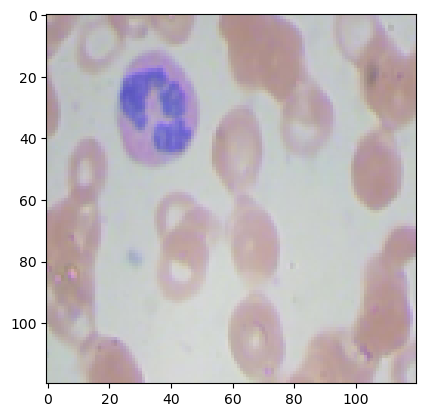

In [27]:

# Exploring Images
def display_img(img,label):
    print(f"Label : {data_train.classes[label]}")
    plt.imshow(img.permute(1,2,0))

#display the first image in the dataset
display_img(*data_train[2])


In [28]:
batch_size = 128
train = DataLoader(data_train, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
test = DataLoader(data_test, batch_size*2, num_workers = 4, pin_memory = True)

In [29]:
# Architecture of our CNN Model:
class BloodCell(nn.Module):
    def __init__(self):
        super().__init__()
        
        # NETWORK
        self.network = nn.Sequential(
            
            # 1
            nn.Conv2d(3, 16, kernel_size = 3 , stride = (2,2) , padding = 2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(16),
            nn.Dropout(p=0.2),
            nn.MaxPool2d(kernel_size =3, stride = 2),
            
            # 2
            nn.Conv2d(16, 8, kernel_size = 3 , stride = (2,2) , padding = 2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
            nn.BatchNorm2d(8),
            nn.Dropout(p=0.2),
            nn.MaxPool2d(kernel_size =3, stride = 2),
            
            # 3
            nn.Conv2d(8, 4, kernel_size = 3, stride = (2,2), padding = 2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            nn.Dropout(p=0.2),
            nn.MaxPool2d(kernel_size =3, stride = 2),
        )
            
        # AVGPOOL
        self.avgpool = nn.AdaptiveAvgPool2d((14,14))
        
        # CLASSIFIER
        self.classifier = nn.Sequential(
            
            nn.Flatten(),
            nn.Linear(14*14*4,200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50,5),
            nn.ReLU(inplace=True),
        )
    
    def forward(self, xb):
        xb = self.network(xb)
        xb = self.avgpool(xb)
        xb = self.classifier(xb)
        return xb
net = BloodCell()
print(net)

BloodCell(
  (network): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Dropout(p=0.2, inplace=False)
    (10): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(8, 4, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
    (12): ReLU(inplace=True)
    (13): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): Dropout(p=0.2, inplace=False)
    (15): MaxPool2d(

In [30]:
# https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
# LOUIS : A changer et à faire à notre sauce !
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-3)
batch_size=128

for epoch in range (20):
    net.train()
    running_loss = 0.0
    for i, data in enumerate(train, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print("Epoch{} - Training loss : {}".format(epoch,running_loss/len(train)))

Epoch0 - Training loss : 1.600395917892456
Epoch1 - Training loss : 1.6068673133850098
Epoch2 - Training loss : 1.6027030944824219
Epoch3 - Training loss : 1.601607322692871
Epoch4 - Training loss : 1.5954313278198242
Epoch5 - Training loss : 1.5928871631622314
Epoch6 - Training loss : 1.5968222618103027
Epoch7 - Training loss : 1.6052424907684326
Epoch8 - Training loss : 1.5916845798492432
Epoch9 - Training loss : 1.5991826057434082
Epoch10 - Training loss : 1.6024770736694336
Epoch11 - Training loss : 1.5983134508132935
Epoch12 - Training loss : 1.5861008167266846
Epoch13 - Training loss : 1.5986685752868652
Epoch14 - Training loss : 1.589285135269165
Epoch15 - Training loss : 1.6068569421768188
Epoch16 - Training loss : 1.564369797706604
Epoch17 - Training loss : 1.5862600803375244
Epoch18 - Training loss : 1.6007884740829468
Epoch19 - Training loss : 1.5814330577850342
